# Data Analysis for  «STrEAMchick»

*Irina Dabaeva 16.04.2024*

STrEAMchick is a video game digital distribution service. Sales data, user/critic scores, genres, and platforms (e.g. Xbox or PlayStation) are available from open data sources. **The goal is to identify patterns that determine the success of the game.** This will make it possible to identify potentially popular future products and plan advertising campaigns.

**Table of contents:**

1. [Data Preprocessing](#Data-Preprocessing)

2. [EDA](#EDA)

3. [User Profile for Each Region](#User-Profile-for-Each-Region)

4. [Hypothesis Testing](#Hypothesis-Testing)

5. [Conclusion](#Conclusion)

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import requests
import re
from bs4 import BeautifulSoup
import random
from scipy import stats as st
import time

In [2]:
df = pd.read_csv('games.csv')

In [3]:
df.head()

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.describe()

Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000

- Name — name of the game

- Platform — platform

- Year_of_Release — release year

- Genre — genre

- NA_sales — sales in North America (millions of sold copies)

- EU_sales — sales in Europe (millions of sold copies)

- JP_sales — sales in Japan (million of sold copies)

- Other_sales — sales in other regions (millions of sold copies)

- Critic_Score — critics' score (max 100)

- User_Score — users' score (max 10)

- Rating — ESRB ratings (Entertainment Software Rating Board)

In [6]:
# column names to lower case
df.columns = df.columns.str.lower()

In [7]:
# remove rows where no game name
df.dropna(subset=['name'], inplace=True)
df.reset_index(inplace=True,drop=True)

In [8]:
# fill missing data in year_of_release with data from internet
# Web scraping using BeautifulSoup
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:78.0)   Gecko/20100101 Firefox/78.0", 
"Referer": "https://www.google.com"}

for i in range(0, len(df)):
    if pd.isnull(df.loc[i, 'year_of_release']):
        URL = 'https://www.google.com/search?q={' + df['name'][i].replace(' ', '+') + '+' + df['platform'][i] + '+' + 'release+year}&hl={en}'
        req = requests.get(URL, headers=headers)
        soup = BeautifulSoup(req.text, 'lxml') 
        year = 0
        txt = ''
        for div in soup.find_all('div'):
            txt += div.text
        year = re.search('Release[A-Za-z0-9 .:,()]*[1-2][09][0-9][0-9]', txt)
        if pd.isnull(year) == False:
            year = year.group()
            year = re.search('[1-2][09][0-9][0-9]', year).group()
            year = int(year)
            if year <= 2017 and year > 1950:
                df.loc[i, 'year_of_release'] = year

In [9]:
df[df['year_of_release'].isna()]

name platform  year_of_release  \
183                      Madden NFL 2004      PS2              NaN   
377                     FIFA Soccer 2004      PS2              NaN   
456           LEGO Batman: The Videogame      Wii              NaN   
475           wwe Smackdown vs. Raw 2006      PS2              NaN   
609                       Space Invaders     2600              NaN   
...                                  ...      ...              ...   
16371  PDC World Championship Darts 2008      PSP              NaN   
16403                      Freaky Flyers       GC              NaN   
16446                          Inversion       PC              NaN   
16456        Hakuouki: Shinsengumi Kitan      PS3              NaN   
16520                       Virtua Quest       GC              NaN   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   
377          Sports      0.59      2.36      0.04         0.51          84.0   
456          Action      1.80      0.97      0.00         0.29          74.0   
475        Fighting      1.57      1.02      0.00         0.41           NaN   
609         Shooter      2.36      0.14      0.00         0.03           NaN   
...             ...       ...       ...       ...          ...           ...   
16371        Sports      0.01      0.00      0.00         0.00          43.0   
16403        Racing      0.01      0.00      0.00         0.00          69.0   
16446       Shooter      0.01      0.00      0.00         0.00          59.0   
16456     Adventure      0.01      0.00      0.00         0.00           NaN   
16520  Role-Playing      0.01      0.00      0.00         0.00          55.0   

      user_score rating  
183          8.5      E  
377          6.4      E  
456          7.9   E10+  
475          NaN    NaN  
609          NaN    NaN  
...          ...    ...  
16371        tbd   E10+  
16403        6.5      T  
16446        6.7      M  
16456        NaN    NaN  
16520        5.5      T  

[269 rows x 11 columns]

In [10]:
# fill missing year mannualy for some observations
df.loc[3080, 'year_of_release'] = 2011
df.loc[718, 'year_of_release'] = 2006
df.loc[6132, 'year_of_release'] = 2005
df.loc[4817, 'year_of_release'] = 2011
df.loc[6254, 'year_of_release'] = 2004
df.loc[9705, 'year_of_release'] = 2013
df.loc[11432, 'year_of_release'] = 2008
df.loc[13780, 'year_of_release'] = 2008
df.loc[14683, 'year_of_release'] = 2010
df.loc[15077, 'year_of_release'] = 2006
df.loc[15117, 'year_of_release'] = 2009
df.loc[16178, 'year_of_release'] = 2010
df.loc[16456, 'year_of_release'] = 2008
df.loc[15955, 'year_of_release'] = 2010
df.loc[15814, 'year_of_release'] = 2005

In [11]:
# remove rows with no year (e.g. web scraping failed)
df.dropna(subset=['year_of_release'], inplace=True)
df.reset_index(inplace=True,drop=True)
# transform year_of_release to integer type
df['year_of_release'] = df['year_of_release'].astype('int')
# make same range
df['critic_score'] = df['critic_score'] / 10
# change tbd to NaN
df['user_score'] = df['user_score'].replace('tbd', np.NaN)

One notable thing is that both user scores and critic scores should have the same range.

'tbd' means 'to be determined', which means scores will be determined shortly.

Generally speaking, user_score and critic_score must be relatively the same, therefore let's fill missing values within the column with either user_score or critic_score accordingly. No data about the game (i.e., the game was released recently or it's not very popular) can lead to missing values in certain columns. 

In [12]:
# fill missing values critic_score or user_score 
for i in range(0, len(df)):
    if(not pd.isnull(df['critic_score'][i])):
        if(pd.isnull(df['user_score'][i])):
            # create small differences in score values
            tmp = random.uniform(-1, 1)
            df.loc[i, 'user_score'] = round(df['critic_score'][i] + tmp,2)
    else:
        if(not pd.isnull(df['user_score'][i])):
            tmp = random.uniform(-1, 1)
            df.loc[i, 'critic_score'] = round(float(df['user_score'][i]) + tmp,2)
            
# check proportion of missing data in each column
print('Доля пропущенных значений:')
print(round(df.isna().mean(),2))

# transform user_score into decimal
df['user_score'] = df['user_score'].astype(float)

Доля пропущенных значений:
name               0.00
platform           0.00
year_of_release    0.00
genre              0.00
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score       0.48
user_score         0.48
rating             0.41
dtype: float64


Therefore proportion of missing values in critic_score, user_score, and rating is less than 50%.

Let's calculate total sales in every region.

In [13]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

The ESRB was founded in 1994, but the dataset contains data from 1977. This may explain the gaps in the rating. Also, "E" was originally called "K-A", so let's change the abbreviation.

In [14]:
df.loc[df['rating']=='K-A', 'rating'] = 'E'

- «EC» - Early childhood
 
- «E» - Everyone
 
- «E10+» - Everyone 10 and older
 
- «T» - Teen  
 
- «M» - Mature
 
- «AO» - Adults Only 18+
 
- «RP» - Rating Pending

Удалим дубликаты, явные и неявные.

In [15]:
print('Duplicates', len(df[df.duplicated()]), '\n')
ind = df[df.duplicated(['name', 'platform'])].index
df = df.drop(ind)
print('Other duplicates:', len(df[df.duplicated(['name', 'platform'])]))

Duplicates 0 

Other duplicates: 0


In [16]:
# we don't want new_df pointing to df therefore use copy()
new_df = df.copy()

**Conclusion:**

- Filled and removed rows with missing values. Now percentage of missing data in critic_score, user_score and rating is less than 50%

- Changed data type of year_of_release and user_score

- Removed duplicates (ones with similar names and platforms)

- Calculated total sales

## EDA

In [17]:
sns.set_style("whitegrid")
colors = ['#0460c9', '#e34020', '#ff8000', '#03a356', '#d96aa0', '#d0de66', '#4a7872', '#ae6cd4']

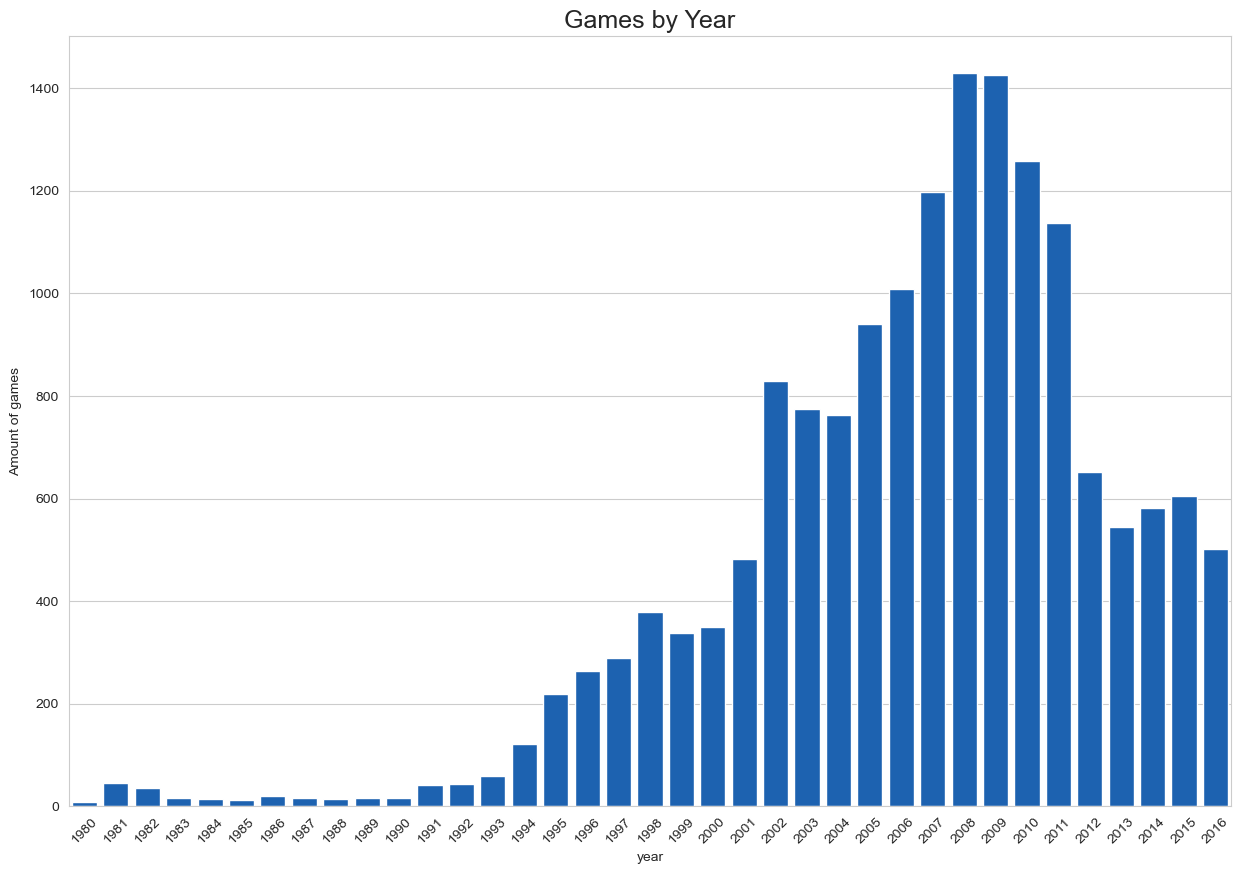

In [18]:
games_by_year = pd.pivot_table(new_df, values='name', index='year_of_release', aggfunc='count').reset_index()

plt.figure(figsize=(15, 10))

sns.barplot(x='year_of_release', y='name', data=games_by_year, color=colors[0])

plt.title('Games by Year', fontsize=18)
plt.xlabel('year')
plt.ylabel('Amount of games')
plt.xticks(rotation=45)
plt.show()

Starting from the 90s the amount of games was increasing rapidly. However, in 2012 we can see a noticable decline. We should focus on the data from recent years (2013-2016) because some platforms are not relevant anymore.  

In [19]:
sales_by_platform = (pd.pivot_table(new_df, values='total_sales', index='platform', aggfunc='sum')
                    .reset_index().sort_values(by='total_sales', ascending=False))
print(sales_by_platform.head(8))
top_eight_platforms = list(sales_by_platform['platform'].head(8))

   platform  total_sales
16      PS2      1233.56
28     X360       960.02
17      PS3       931.34
26      Wii       893.50
4        DS       803.46
15       PS       727.58
18      PS4       314.14
6       GBA       313.16


The best platforms are PS2 and X360.

In [20]:
def plot_line(dt, palette, ttl):
    
    plt.figure(figsize=(18,10))

    sns.lineplot(data=dt, x="year_of_release", y="total_sales", hue="platform", marker='o', lw=2, palette=palette)

    plt.title(ttl, fontsize=18)
    plt.xlabel('year')
    plt.ylabel('Sales, mln. copies')
    plt.xticks(rotation=45)
    plt.show()

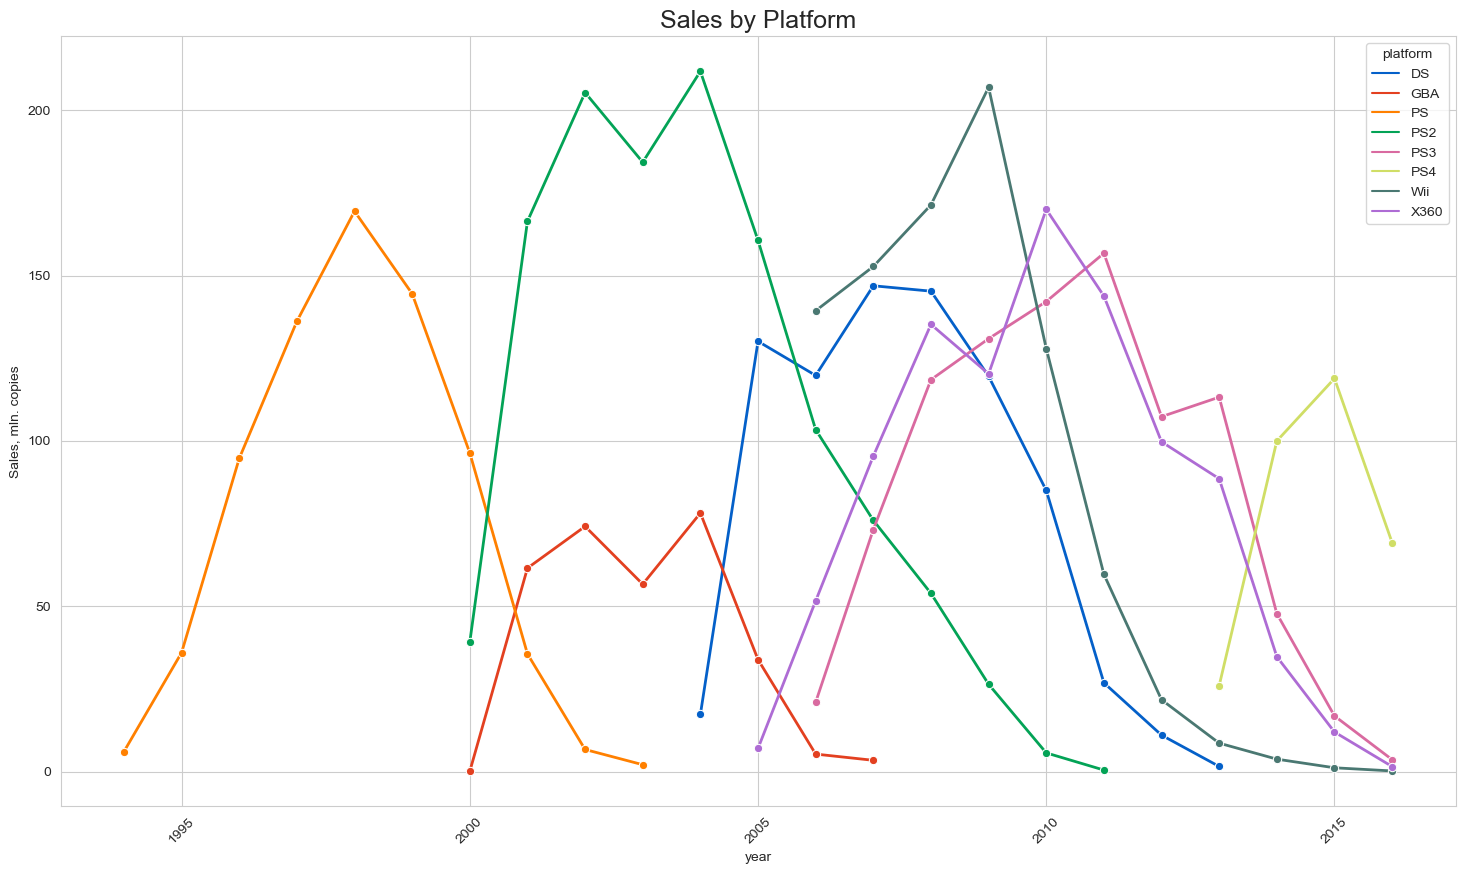

In [21]:
sales_by_platform = (pd.pivot_table(new_df, values='total_sales', index={'year_of_release','platform'}, aggfunc='sum')
                     .reset_index())
sales_by_platform = sales_by_platform[sales_by_platform['platform'].isin(top_eight_platforms)]
    
plot_line(sales_by_platform, colors, 'Sales by Platform')

The "Expiration date" of a platform is approximately 10 years on average. That's why it's better to analyze data for the past 4-5 years. So, platforms for which sales just started to increase probably will display positive trends in the future. 

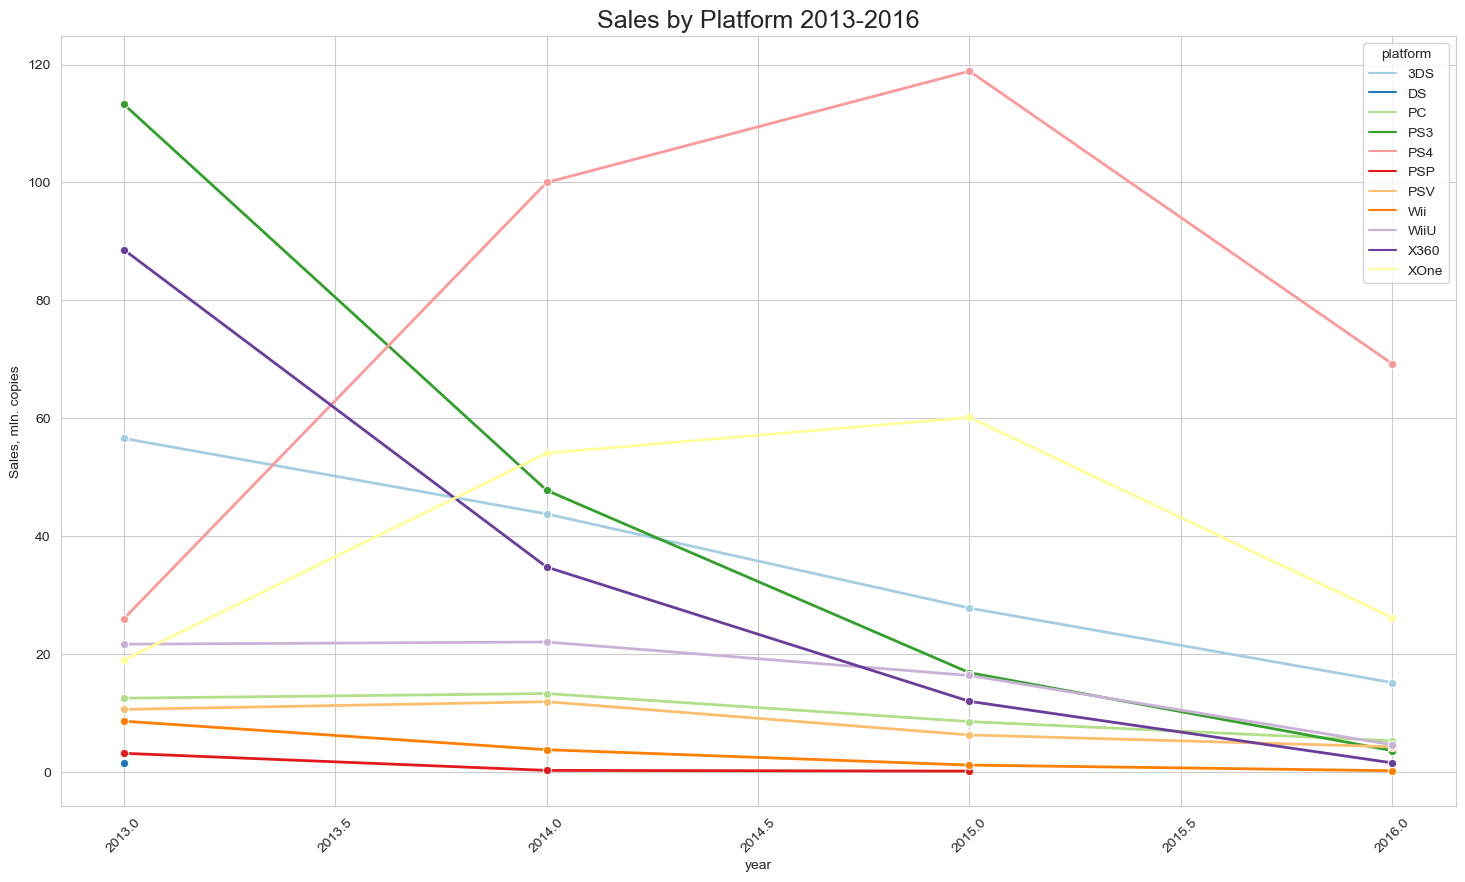

In [22]:
from_2013 = new_df[new_df['year_of_release'] >= 2013].copy()

palette = sns.color_palette('Paired', 11)

sales_by_platform = (pd.pivot_table(from_2013, values='total_sales', index={'year_of_release','platform'}, aggfunc='sum')
                     .reset_index())

plot_line(sales_by_platform, sns.color_palette('Paired', 11), 'Sales by Platform 2013-2016')

At the beginning of 2013, PS3 and X360 lead in sales, but closer to 2014, PS4 takes the lead. The slight decrease in total sales for this platform in 2016 can be explained by a lack of data for this year. Also, for other platforms, the demand is minimal or non-existent.

PS4 and Xbox One can be considered potentially profitable.

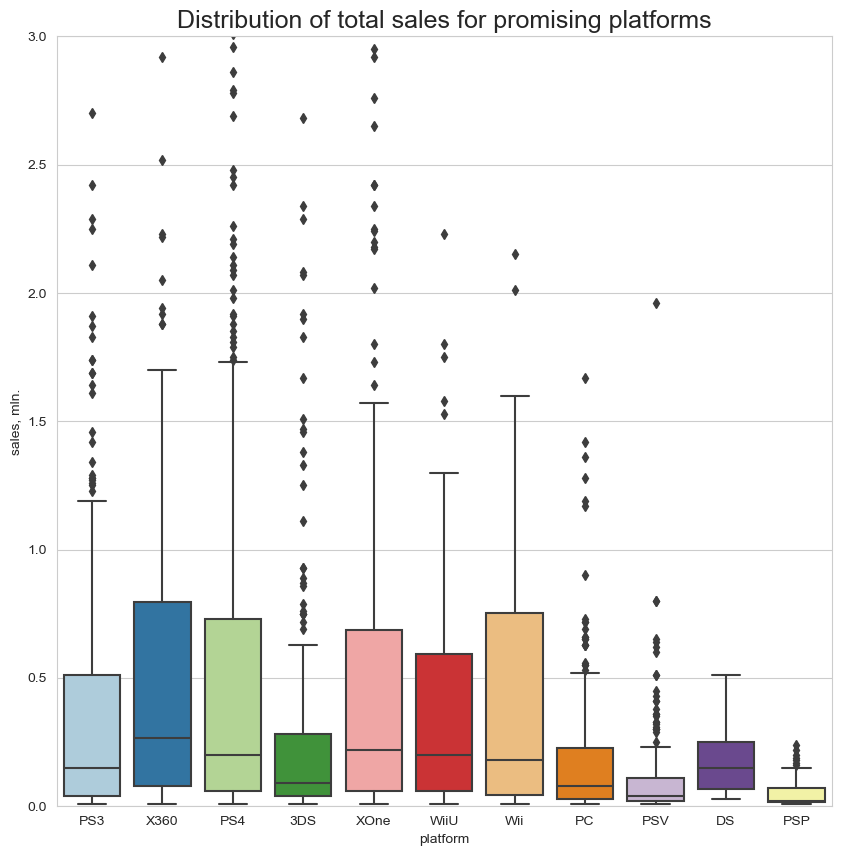

In [23]:
plt.figure(figsize=(10,10))

sns.boxplot(x='platform', y='total_sales', data=from_2013, palette=palette)

plt.ylim([0,3])
plt.title('Distribution of total sales for promising platforms', fontsize=18)
plt.xlabel('platform')
plt.ylabel('sales, mln.')
plt.show()

- You can see that X360, PS4, PS3, XOne, WiiU, Wii and DS consistently generate high income.

- Median for X360 ~250,000. For PS4 and XOne ~200,000.

- A large number of outliers may indicate the presence of bestsellers.

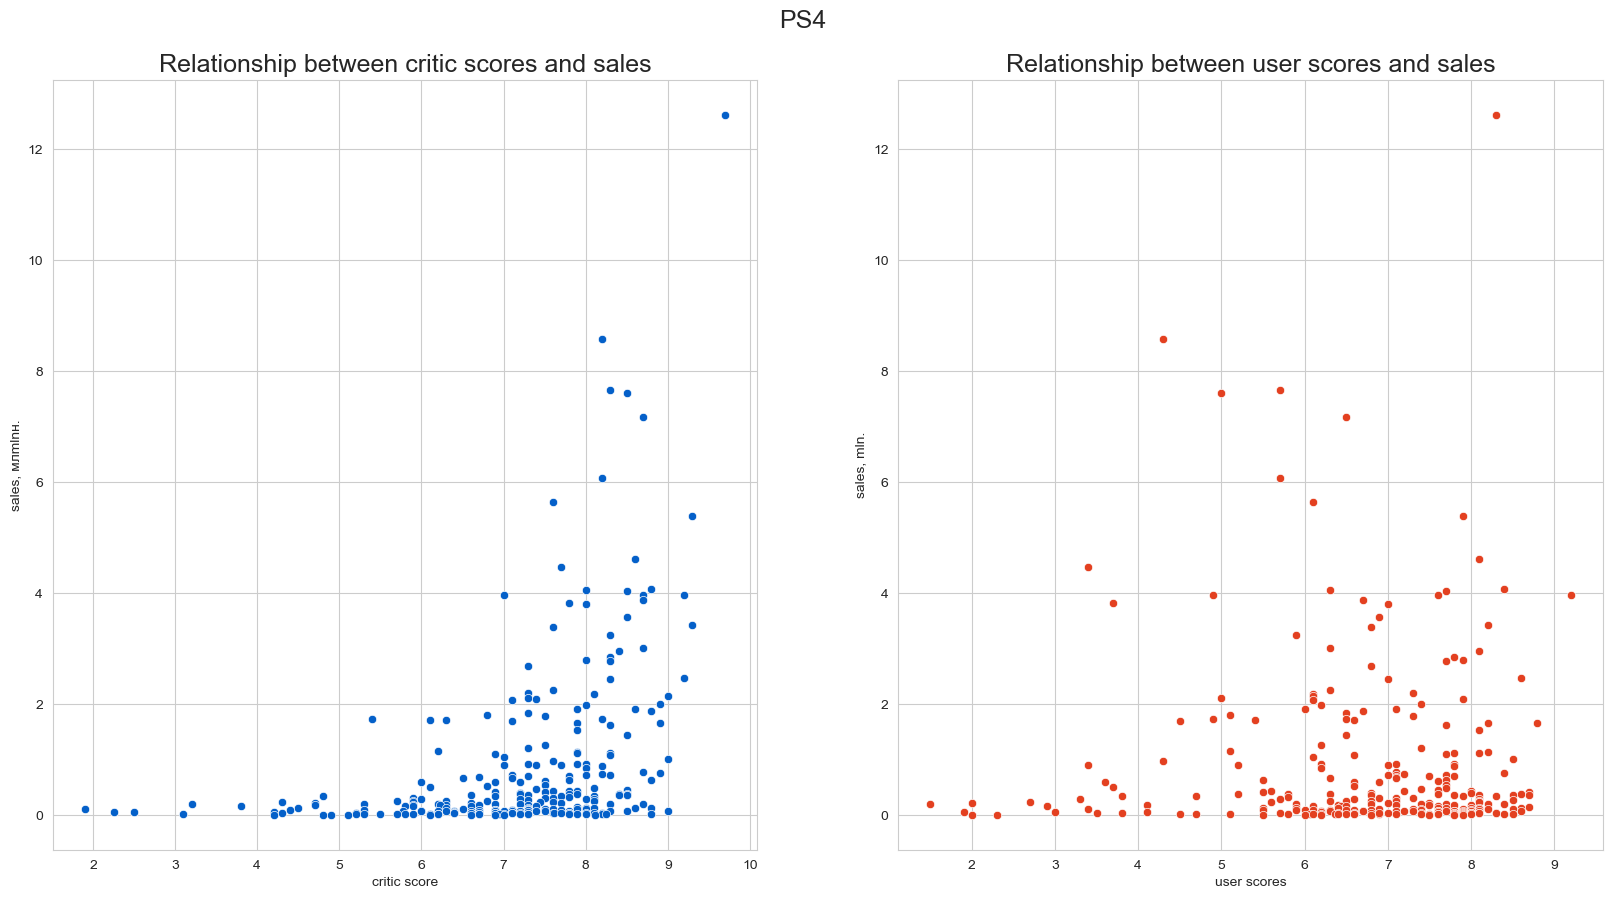

In [24]:
def plot_scatter(condition):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.suptitle(condition.upper(), fontsize=18, y=0.95)

    sns.scatterplot(data=from_2013[from_2013['platform']==condition], x='critic_score', y='total_sales', color=colors[0], ax=axs[0])
    axs[0].set_title('Relationship between critic scores and sales', fontsize=18)
    axs[0].set_xlabel('critic score')
    axs[0].set_ylabel('sales, млmlnн.')

    sns.scatterplot(data=from_2013[from_2013['platform']==condition], x='user_score', y='total_sales', color=colors[1], ax=axs[1])
    axs[1].set_title('Relationship between user scores and sales', fontsize=18)
    axs[1].set_xlabel('user scores')
    axs[1].set_ylabel('sales, mln.')

    plt.show()
    
plot_scatter('PS4')

In [25]:
def print_cor(condition):
    print('platform', condition)
    cor = from_2013[from_2013['platform']==condition]['total_sales'].corr(from_2013[from_2013['platform']==condition]['critic_score'])
    print('correlation between critic scores and sales:', round(cor,3))
    cor = from_2013[from_2013['platform']==condition]['total_sales'].corr(from_2013[from_2013['platform']==condition]['user_score'])
    print('correlation between user scores and sales:', round(cor,3))

In [26]:
print_cor('PS4')

platform PS4
correlation between critic scores and sales: 0.398
correlation between user scores and sales: -0.03


According to the graph, you can see that reviews from critics to one degree or another affect the sales of games, which cannot be said about user reviews. Additionally, the correlation between user reviews and sales is -0.031, there is no linear correlation between the two variables.

In [27]:
values_genre = from_2013['genre'].value_counts()

fig = go.Figure(data=[go.Pie(labels=values_genre.index, values=values_genre.values)])
fig.update_layout(title='genres', width=900, height=700)
fig.update_traces(textposition='inside', textinfo='percent+label+text')
fig.show() 

Action games make up approximately 34% of all games.

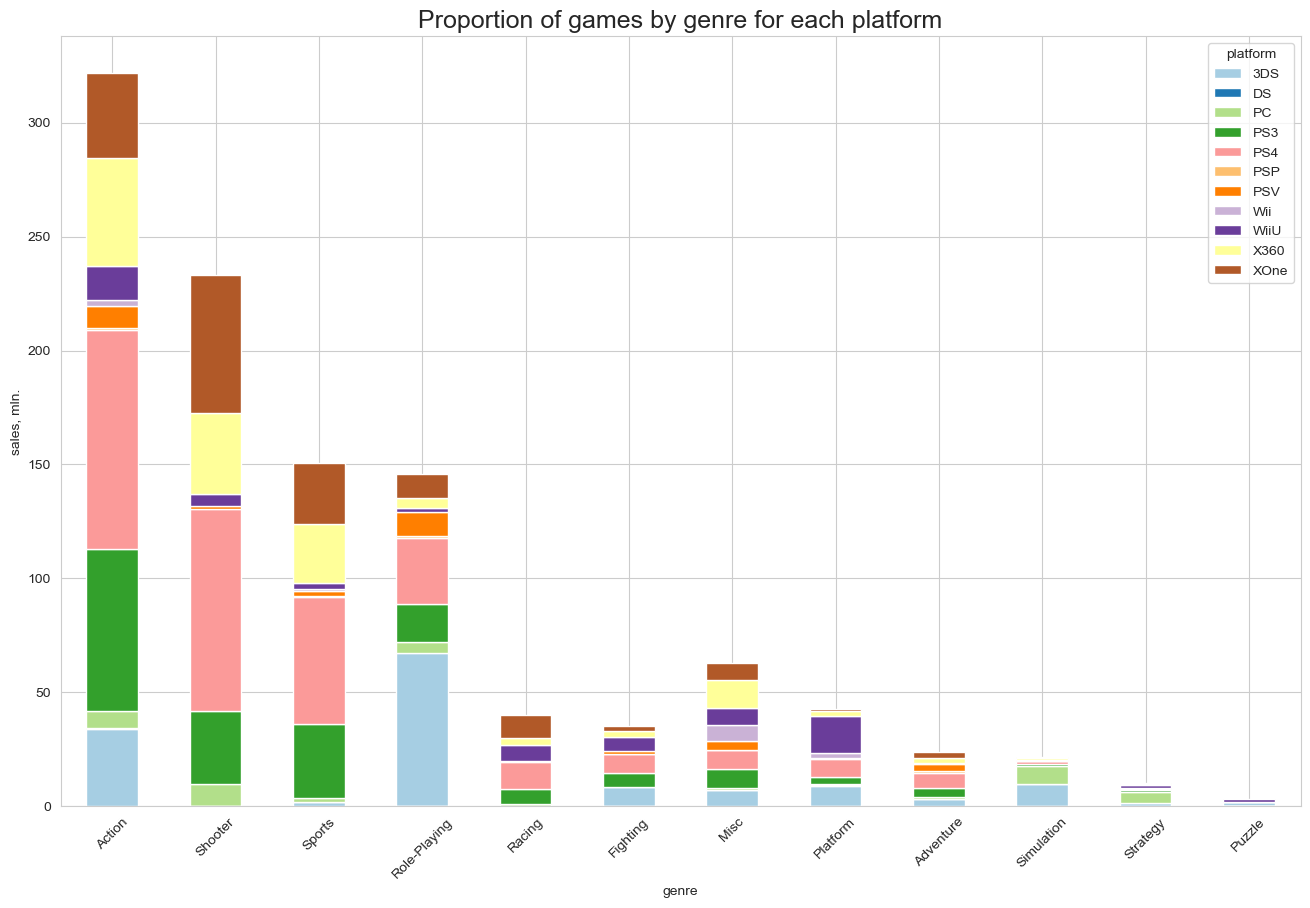

In [28]:
by_genre = from_2013.pivot_table(index = 'genre', columns = 'platform', values = 'total_sales', aggfunc='sum')

fig, ax = plt.subplots(figsize=(16, 10))

by_genre.sort_values(by='PS4', ascending=False).plot(kind='bar',stacked=True, ax=ax, cmap='Paired')

plt.title('Proportion of games by genre for each platform', fontsize=18)
plt.xlabel('genre')
plt.ylabel('sales, mln.')
plt.xticks(rotation=45)
plt.show()

- The biggest sales are for games in the Action, Shooter, Sports and Role-Playing genres;

- Despite the relatively large number of Adventure games, their sales are not that high;

- Action games sold well on PS3 and PS4. While Shooter is popular on PS4 and XOne. RPG games sold well on the 3DS.

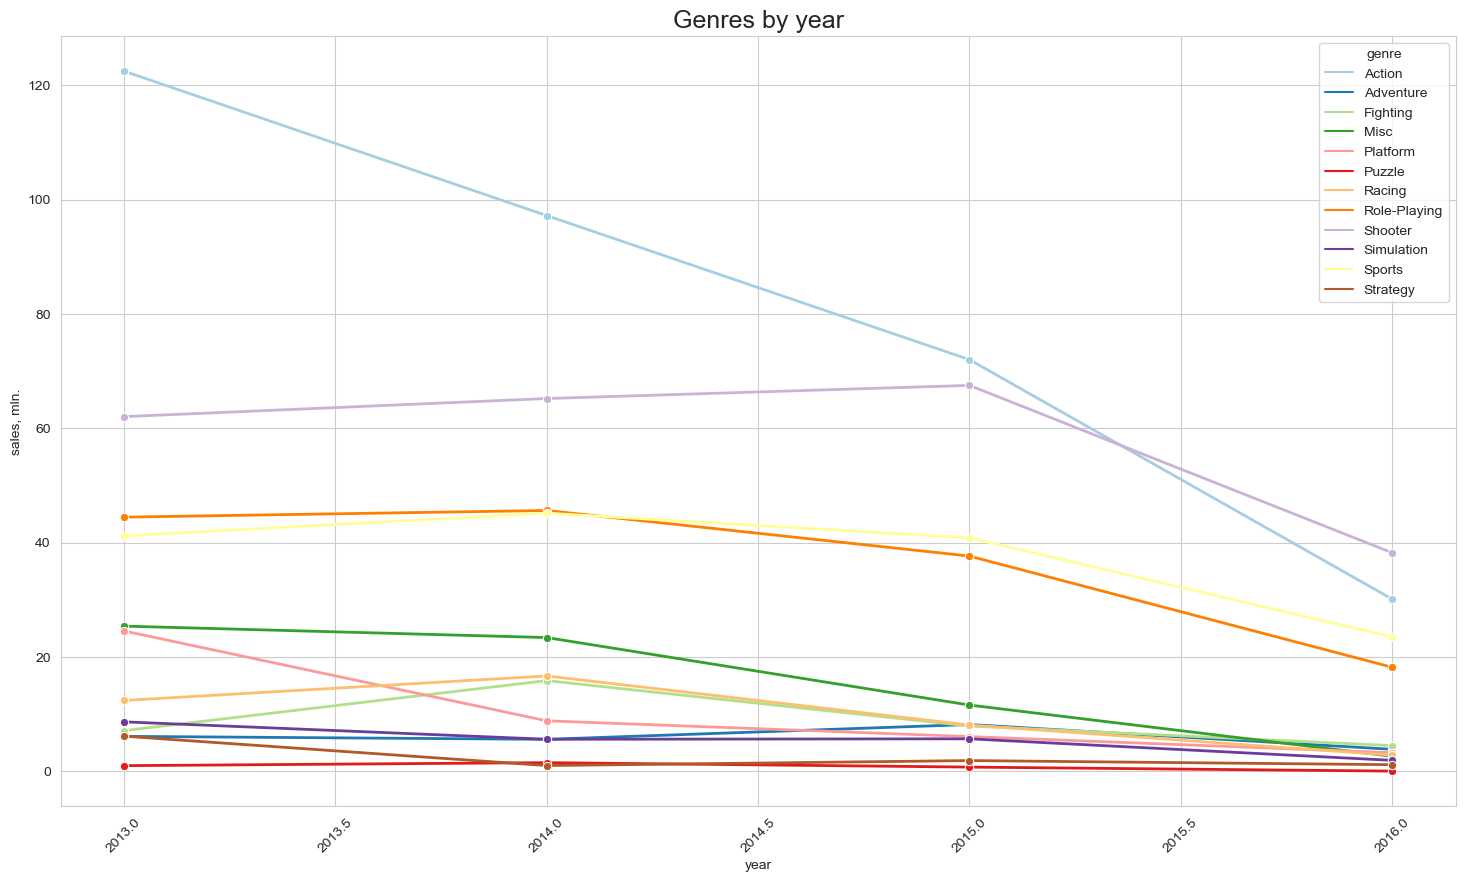

In [29]:
sales_by_genre = (pd.pivot_table(from_2013, values='total_sales', index={'year_of_release', 'genre'}, aggfunc='sum')
                     .reset_index())

plt.figure(figsize=(18,10))

sns.lineplot(data=sales_by_genre, x="year_of_release", y="total_sales", 
             hue="genre", marker='o', palette=sns.color_palette('Paired', 12), lw=2)

plt.title('Genres by year', fontsize=18)
plt.xlabel('year')
plt.ylabel('sales, mln.')
plt.xticks(rotation=45)
plt.show()

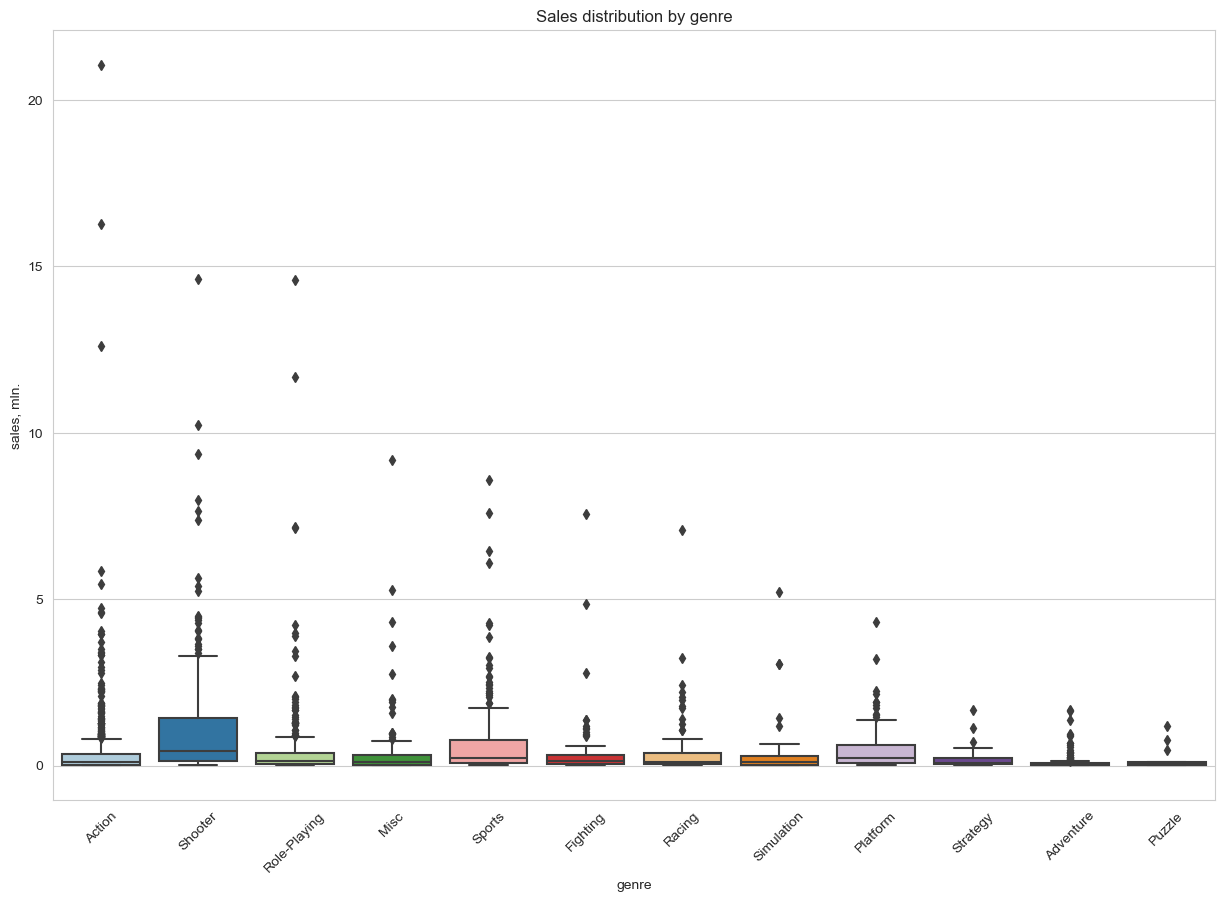

In [30]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

ax = sns.boxplot(x='genre', y='total_sales', data=from_2013, palette=sns.color_palette('Paired', 12))

plt.title('Sales distribution by genre')
plt.xlabel('genre')
plt.ylabel('sales, mln.')
plt.xticks(rotation=45)
plt.show()

- In 2016, games in the Shooter genre are in 1st place, surpassing Action games in total sales.

- In 2015, Sports overtook Role-Playing in total sales. This may be due to the fact that games in this genre are popular on the Nintendo 3DS, but the platform has not been as relevant as the PS4 and XOne over the past few years.

- If you look at median sales, Shooter games show the best results. Sports and Platform also generate consistently high income.

## User Profile for Each Region

<Axes: xlabel='platform'>

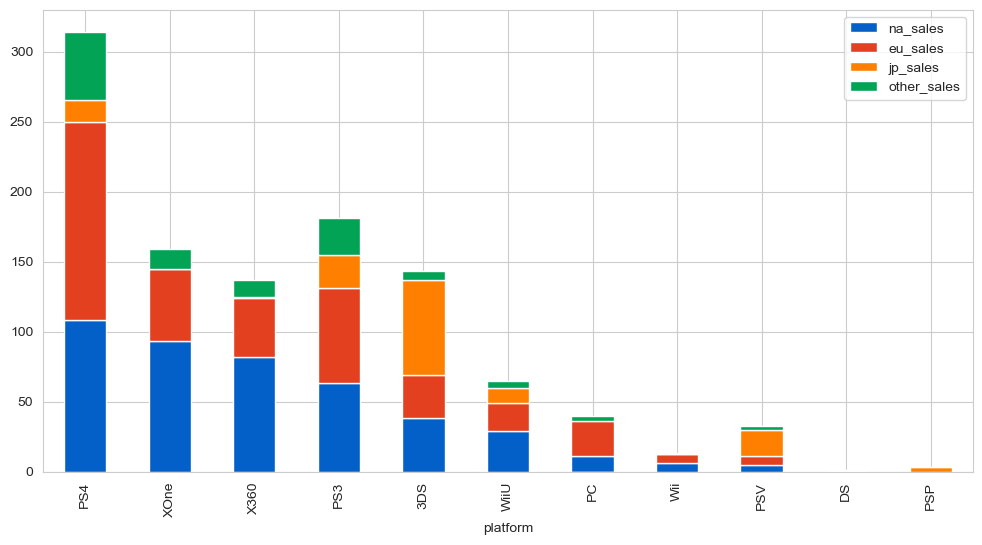

In [31]:
platform_by_region = from_2013.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
platform_by_region.sort_values(by='na_sales', ascending=False).plot(kind='bar',stacked=True, figsize=(12,6), color=colors)

In [32]:
platform_by_region.apply(lambda x: x / x.sum(), axis=0).style.format("{:.1%}")

- Playstation is popular all over the world;

- If we take into account only 3 regions (North America, Europe, Japan), then European users prefer PS the most (52%);

- In America, players prefer consoles from Microsoft (40%);

- In Japan, Nintendo is preferred (48%).

<Axes: xlabel='genre'>

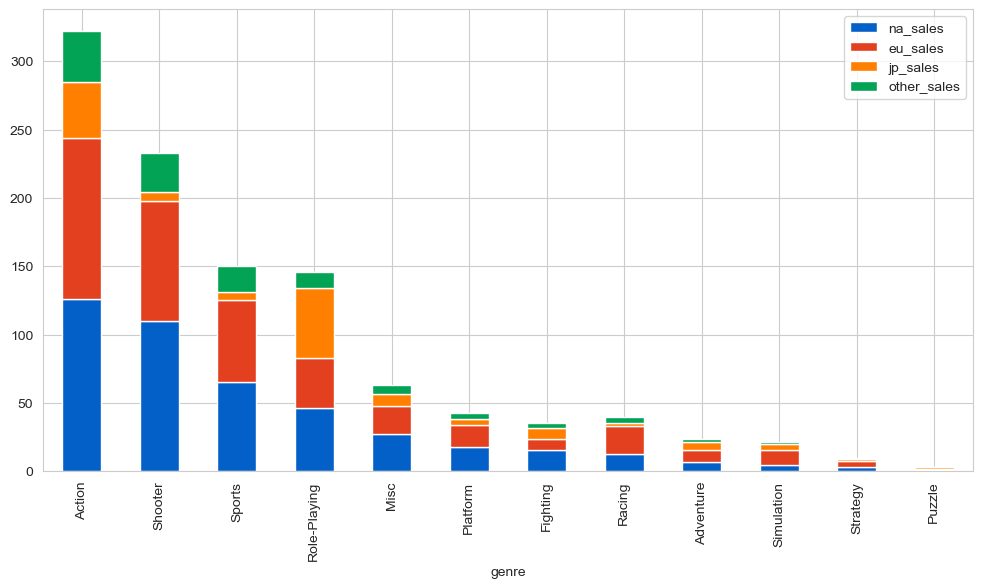

In [33]:
genre_by_region = from_2013.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
genre_by_region.sort_values(by='na_sales', ascending=False).plot(kind='bar',stacked=True, figsize=(12,6), color=colors)

In [34]:
genre_by_region.apply(lambda x: x / x.sum(), axis=0).style.format("{:.1%}")

Players from Europe and North America prefer games of the Action, Shooter, Sports genre. In Japan people like to play RPGs more.

<Axes: xlabel='rating'>

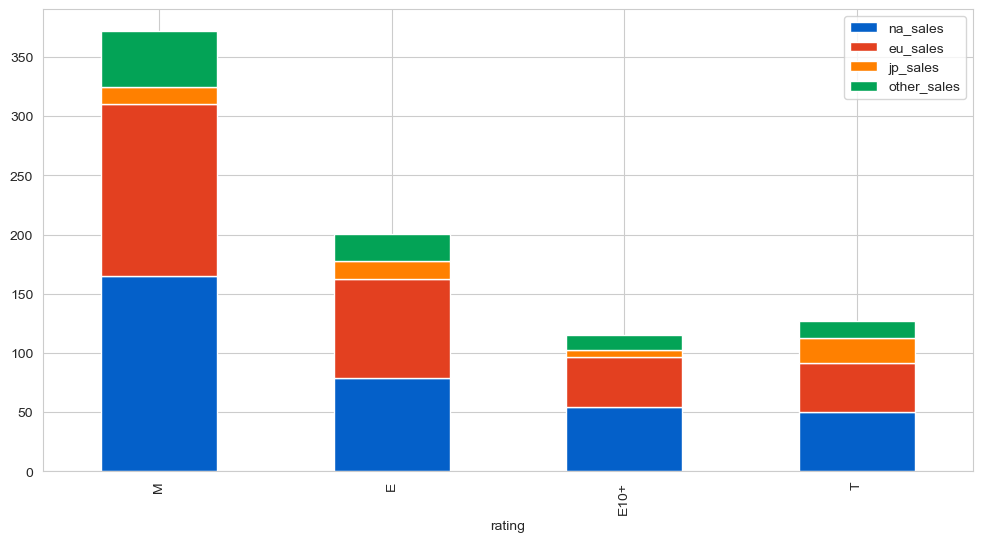

In [35]:
rating_by_region = from_2013.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
rating_by_region.sort_values(by='na_sales', ascending=False).plot(kind='bar',stacked=True, figsize=(12,6), color=colors)

In [36]:
rating_by_region.apply(lambda x: x / x.sum(), axis=0).style.format("{:.1%}")

Since Action and Shooter games tend to have higher ratings, and these genres are more popular in America and Europe, which may explain the high sales of high-rated games in these regions.

## Hypothesis Testing

If data has not normal distribution, it's a good practice to use the Mann–Whitney U test. 

Significance level = 0.05

In [37]:
def check_norm(sample):
    
    alpha = 0.05  

    results = st.shapiro(sample)
    p_value = results[1]  

    if p_value < alpha:
        print('reject null hypothesis: distribution is not normal')
    else:
        print('fail to reject null hypothesis, data is normal') 
        
def t_test(sample1, sample2):
    
    alpha = 0.05 

    results = st.ttest_ind(sample1, sample2, alternative='two-sided')

    print('p-value:', results.pvalue)

    if results.pvalue < alpha:
        print('reject null hypothesis')
    else:
        print('fail to reject null hypothesis') 

def Mann_Whitney(sample1, sample2):
    
    alpha = 0.05  # критический уровень статистической значимости

    results = st.mannwhitneyu(sample1, sample2)

    print('p-value: ', results.pvalue)

    if results.pvalue < alpha:
        print('reject null hypothesis: statistically significant')
    else:
        print(
            'fail to reject'
        ) 

H0: There are no differences between the average user ratings for the Xbox One and PC platforms.

Ha: There are differences between the groups.

In [38]:
sample_1 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['platform']=='XOne']['user_score']))
sample_2 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['platform']=='PC']['user_score']))

check_norm(sample_1)
check_norm(sample_2)

reject null hypothesis: distribution is not normal
reject null hypothesis: distribution is not normal


We use the nonparametric Wilcoxon-Mann-Whitney test:

In [39]:
Mann_Whitney(sample_1, sample_2)

p-value:  0.6250503015640279
fail to reject


The null hypothesis could not be rejected. The average user ratings for the Xbox One and PC platforms are the same.

H0: There is no difference between the average user ratings of the Action and Sports genres.

Ha: There are differences between the groups.

In [40]:
sample_1 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['genre']=='Action']['user_score']))
sample_2 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['genre']=='Sports']['user_score']))

check_norm(sample_1)
check_norm(sample_2)

reject null hypothesis: distribution is not normal
reject null hypothesis: distribution is not normal


In [41]:
Mann_Whitney(sample_1, sample_2)

p-value:  5.844032688071388e-24
reject null hypothesis: statistically significant


We reject the null hypothesis. The average user ratings for the Action and Sports genres are different.

## Conclusion

Based on the analysis of the data provided for 2013-2016 we were able to identify:

- Critic ratings have minimal impact on sales, and user ratings have no impact at all. 

- For the entire period since 2013 X360, PS4, PS3, XOne, WiiU, Wii and DS generated consistently high revenue (median ~200,000 copies)

- Judging by the graph of total sales by platform, PlayStation 4 and Xbox One are the most potentially profitable platforms

- If you look at median sales, then Shooter games show the best results. Sports and Platform also bring consistently high revenue

- European users prefer PS the most (percentage of players in the region is 52%). In America, players prefer consoles from Microsoft (percentage of players in the region is 40%). In Japan customers like Nintendo consoles (48% of players in the region)

- In America and Europe, games of the Action and Shooters genre are preferred (percentage of players in the regions > 50%). As a rule, games of these genres have higher ratings. In Japan, RPGs are more popular (percentage of players in the region is 36%)

We also tested some hypotheses and found that with alpha = 5%:

- Average user ratings for Xbox One and PC platforms are the same

- Average user ratings for Action and Sports genres are different.